## Imports

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"


import numpy as np 
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from matplotlib import animation
from IPython.display import HTML

In [2]:
i2action = {
    0:'left',
    1:'down',
    2:'right',
    3:'up'
}

## Utils

In [3]:
def evaluate_policy(env, q_values, policy_method, gamma=1.0, n=100):
    rewards = []
    for _ in range(n):
        state = env.reset()[0]
        total_reward = 0
        done = False
        while not done:
            action = policy_method(q_values, state)
            state, reward, done, _, _ = env.step(action)

            total_reward += reward
        rewards.append(total_reward)

    return np.mean(rewards)

def print_policy(policy):
    field_len = 4 
    policy_txt = np.chararray((field_len, field_len), 10)
    # Policy presented as Q-table
    if len(policy.shape) == 2:
        n = policy.shape[1]
        p = np.array(np.argmax(policy, axis=1)).reshape(field_len, field_len)
        
        for i in range(field_len):
            for j in range(field_len):
                policy_txt[i][j] = i2action[p[i][j]]

    else: # Policy is given directly
        for i in range(field_len):
            for j in range(field_len):
                policy_txt[i][j] = i2action[policy[i * field_len + j]]
    print(policy_txt)

## FrozenLake

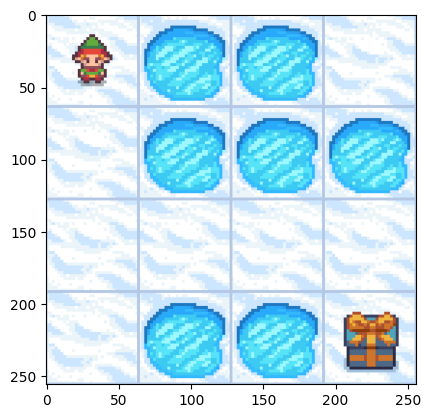

In [56]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array", desc=generate_random_map(size=4, p=0.4), is_slippery=False)
env.reset()
plt.imshow(env.render())

## Q-learning

In [57]:
def e_greedy_policy(q_values, state, eps=0.2):
    rand = np.random.rand()
    if rand < eps:
        return env.action_space.sample()
    else:
        return np.argmax(q_values[state])

def greedy_policy(q_values, state):
    return np.argmax(q_values[state])  

In [58]:
def q_learning(
    env,
    policy_method,
    episode_num=1000,
    gamma=1.0,
    alpha=0.1,
    eps=0.2
):
    q_values = np.zeros(shape=(env.observation_space.n, env.action_space.n)) 

    scores = []
    for _ in tqdm(range(episode_num)):

        state = env.reset()[0]
        done = False
        step_i = 1
        while not done:
            action = policy_method(q_values, state, eps)

            new_state, reward, done, _, p = env.step(action)
            reward -= 1

            if state == new_state: # stuck in wall
                reward -= 10
            if done and new_state != 15:
                reward -= 100
            if new_state == 15:
                reward += 100
            
            discount_factor = gamma ** step_i
            q_values[state, action] += alpha * (reward + discount_factor * np.max(q_values[new_state]) - q_values[state, action])
            state = new_state
            step_i += 1
            

        score = evaluate_policy(env, q_values, policy_method, n=100)
        scores.append(score)
        # if score > 1 - eps:
            # break

    return q_values, scores

100%|██████████| 100/100 [00:00<00:00, 157.91it/s]


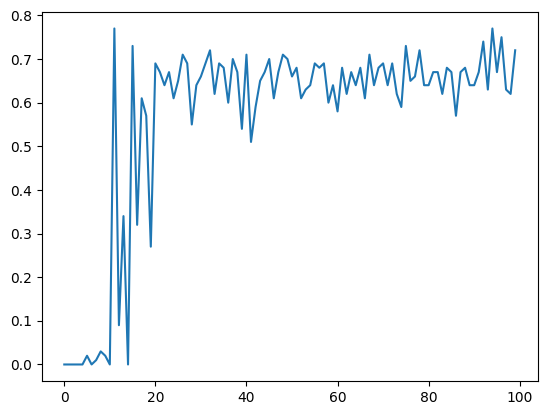

In [62]:
q_values, scores = q_learning(env, e_greedy_policy, episode_num=100, gamma=0.9, alpha=0.1, eps=0.0)

plt.plot(scores);

In [ ]:
i2action = {
    0:'left',
    1:'down',
    2:'right',
    3:'up'
}

[[b'down' b'left' b'left' b'left']
 [b'down' b'left' b'left' b'left']
 [b'right' b'right' b'right' b'down']
 [b'up' b'left' b'left' b'left']]


/var/folders/3h/dhhfcbhd3pl2ss8czvd22c080000gn/T/ipykernel_59327/4047669439.py:18: DeprecationWarning: `np.chararray` is deprecated and will be removed from the main namespace in the future. Use an array with a string or bytes dtype instead.
  policy_txt = np.chararray((field_len, field_len), 10)


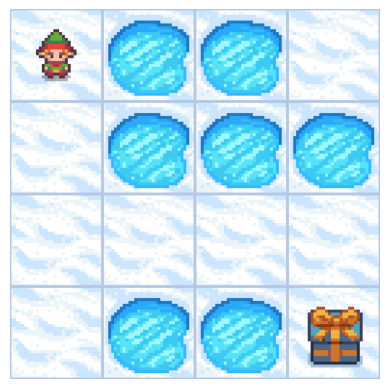

In [63]:
env.reset()
print_policy(q_values);
plt.imshow(env.render());
plt.axis("off");

## Policy iteration

In [67]:
def evaluate_policy(env, policy, gamma, n=100):
    scores = []
    for _ in tqdm(range(n)):
        obs = env.reset()[0]
        total_reward = 0
        step_idx = 0
        done = False
        while not done:
            obs, reward, done , _, _ = env.step(int(policy[obs]))

            total_reward += (gamma ** step_idx * reward)
            step_idx += 1
            if step_idx > 50:
                break
        scores.append(total_reward)
    
    return np.mean(scores)

def extract_policy(v, gamma = 1.0, alpha = 0.9):
    """
    Get new policy according to max Q-func for each state.
    """
    policy = np.zeros(env.observation_space.n)
    q = np.zeros((env.observation_space.n, env.action_space.n))
    for state in env.get_wrapper_attr('P').keys():
        for a in env.get_wrapper_attr('P')[state].keys():
            q_old = q[state, a]
            q[state, a] = np.sum(
                [(1 - alpha) * q_old + alpha * p * (r + gamma * v[s]) for p, s, r, _ in env.get_wrapper_attr('P')[state][a]]
            )
        policy[state] = np.argmax(q[state, :])
    return policy

def compute_policy_v(env, policy, gamma=1.0):
    """
    Compute V - func for all states for current policy.
    """
    v_cur = np.zeros(env.observation_space.n)
    while True:
        v_prev = v_cur.copy()
        for state in range(env.observation_space.n):
            # Value of state = sum of values of all possible next states
            v_cur[state] = np.sum(
                [p * (r + gamma * v_prev[s]) for p, s, r, _ in env.get_wrapper_attr('P')[state][policy[state]]]
            )
        # If V - func converges
        if np.linalg.norm(v_cur - v_prev) < 1e-10:
            break
    return v_cur

def policy_iteration(env, gamma = 1.0, iteration_num = 100):
    policy = np.random.choice(np.arange(env.action_space.n), env.observation_space.n)
    scores = []

    for _ in tqdm(range(iteration_num)):
        old_policy_v = compute_policy_v(env, policy, gamma)
        new_policy = extract_policy(old_policy_v, gamma)

        # If new policy hasn't improved
        if (np.all(policy == new_policy)):
            break

        policy = new_policy
        
        score = evaluate_policy(env, policy, gamma = 0.9, n = 100)
        scores.append(score)
        
        
    return policy, scores

In [68]:
p, scores = policy_iteration(env, gamma=0.9, iteration_num=1000)

  1%|          | 6/1000 [00:00<00:41, 23.86it/s]


In [71]:
plt.plot(scores);

<IPython.core.display.Javascript object>

In [72]:
evaluate_policy(env, p, gamma=1, n=100)

100%|██████████| 100/100 [00:00<00:00, 7217.50it/s]


np.float64(1.0)

In [73]:
print_policy(p)

[[b'down' b'left' b'left' b'left']
 [b'down' b'left' b'left' b'left']
 [b'right' b'right' b'right' b'down']
 [b'up' b'left' b'left' b'left']]


/var/folders/3h/dhhfcbhd3pl2ss8czvd22c080000gn/T/ipykernel_59327/4047669439.py:18: DeprecationWarning: `np.chararray` is deprecated and will be removed from the main namespace in the future. Use an array with a string or bytes dtype instead.
  policy_txt = np.chararray((field_len, field_len), 10)


## Visualization

In [64]:
%matplotlib notebook

In [65]:
def visualize_policy(env, q_table):
    state = env.reset()[0]
    frames = [env.render()]
    done = False

    while not done:
        action = int(np.argmax(q_table[state]))
        
        new_state, _, done, _, _ = env.step(action)
        
        frames.append(env.render())
        state = new_state

    fig = plt.figure(figsize=(4,4))
    def animate_func(i):
        im = plt.imshow(frames[i])
        return im

    anim = animation.FuncAnimation(
        fig, 
        animate_func, 
        frames=len(frames),
        interval=1000,
    );

    return HTML(anim.to_jshtml())

In [66]:
visualize_policy(env, q_values)

<IPython.core.display.Javascript object>